(500,) (500,)


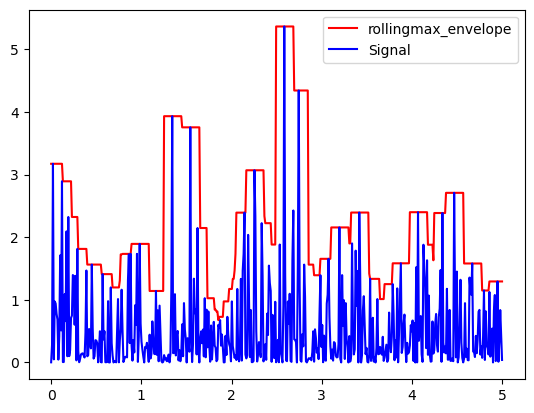

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp

'''#make a chirp signal
duration, fs = 2, 300  # 1 s signal with sampling frequency of 400 Hz
t = np.arange(int(fs*duration)) / fs  # timestamps of samples
signal = chirp(t, 20.0, t[-1], 100.0)
signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )
signal=np.square(signal)'''

#make a very random signal
t = np.linspace(0, 5, 500)  # long enough for jagged detail

# Base signal: combination of sinusoids
signal = (
    0.5 * np.sin(2 * np.pi * 5 * t) +          # low frequency component
    0.3 * np.sin(2 * np.pi * 20 * t) +         # medium frequency
    0.2 * np.sin(2 * np.pi * 80 * t)           # high frequency
)

# Add jaggedness: random impulses and noise
jagged_noise = 0.5 * np.random.randn(len(t))              # white noise
impulses = np.zeros_like(t)
impulse_indices = np.random.choice(len(t), size=50, replace=False)
impulses[impulse_indices] = np.random.choice([-1, 1], size=50)  # sharp spikes

# Final signal
signal = signal + jagged_noise + impulses
signal=np.square(signal)

#hilbert transform, apparently this does not work on signals which have negative lines in them 
analytic_signal = hilbert(signal)
hilbert_envelope = np.abs(analytic_signal)
#Savitzky–Golay Envelope
from scipy.signal import savgol_filter
savgol_envelope = savgol_filter(np.abs(signal), window_length=51, polyorder=3)
#wavelet decomposition envelope
import pywt
coeffs = pywt.wavedec(signal, 'db4', level=4)
# Zero out detail coefficients
coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
wt_envelope = pywt.waverec(coeffs, 'db4')
#rolling max filter----this seems the most well behaved and good stuff!
from scipy.ndimage import maximum_filter1d
rmax_envelope = maximum_filter1d(signal, size=20) 




print(np.shape(signal),np.shape(rmax_envelope))


plt.plot(t, rmax_envelope, label='rollingmax_envelope',color='r')
#plt.plot(t, wt_envelope, label='wt_envelope',color='r')
plt.plot(t, signal, label='Signal', color='b')
#plt.plot(t, savgol_envelope, label='savgol_envelope')
#plt.plot(t, hilbert_envelope, label='hilbert Envelope')

plt.legend()
plt.show()

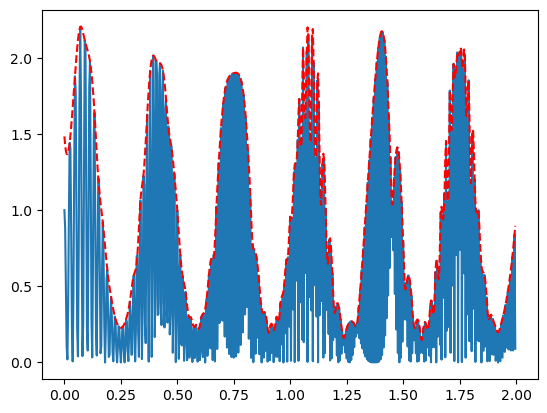

In [47]:
#spline interpolation 

from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline

# Find maxima and minima
max_idx, _ = find_peaks(signal)
min_idx, _ = find_peaks(-signal)

upper_env = CubicSpline(t[max_idx], signal[max_idx])(t)
#lower_env = CubicSpline(t[min_idx], signal[min_idx])(t)



plt.plot(t, signal, label='Original Signal')
plt.plot(t, upper_env, 'r--', label='Upper Envelope')
#plt.plot(t, lower_env, 'b--', label='Lower Envelope')

(500,) (500,)


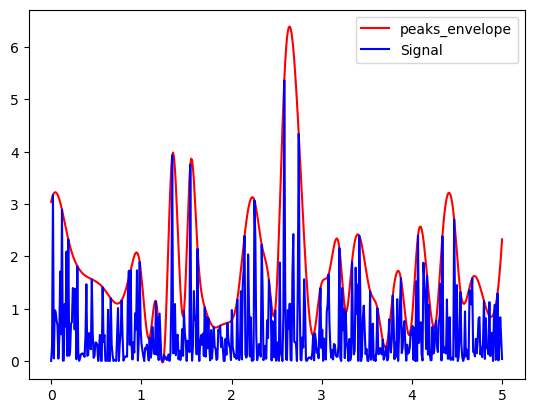

In [84]:
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# Find peaks - this method is probably the best

peaks, _ = find_peaks(signal, distance = 7) #define distance to decrease the resolution of jaggedness, and making it more seamless
peak_times = t[peaks]
peak_values = signal[peaks]

# Interpolate the envelope
envelope_interp = interp1d(peak_times, peak_values, kind='cubic', fill_value='extrapolate')
peak_envelope = envelope_interp(t)

plt.plot(t, peak_envelope, label='peaks_envelope',color='r')

plt.plot(t, signal, label='Signal', color='b')
#plt.plot(t, savgol_envelope, label='savgol_envelope')
#plt.plot(t, hilbert_envelope, label='hilbert Envelope')
print(np.shape(signal),np.shape(peak_envelope))
plt.legend()
plt.show()

In [ ]:
def find_peaks(x, height=None, threshold=None, distance=None,
               prominence=None, width=None, wlen=None, rel_height=0.5,
               plateau_size=None):

    # _argmaxima1d expects array of dtype 'float64'
    x = _arg_x_as_expected(x)
    if distance is not None and distance < 1:
        raise ValueError('`distance` must be greater or equal to 1')

    peaks, left_edges, right_edges = _local_maxima_1d(x)
    properties = {}

    if plateau_size is not None:
        # Evaluate plateau size
        plateau_sizes = right_edges - left_edges + 1
        pmin, pmax = _unpack_condition_args(plateau_size, x, peaks)
        keep = _select_by_property(plateau_sizes, pmin, pmax)
        peaks = peaks[keep]
        properties["plateau_sizes"] = plateau_sizes
        properties["left_edges"] = left_edges
        properties["right_edges"] = right_edges
        properties = {key: array[keep] for key, array in properties.items()}

    if height is not None:
        # Evaluate height condition
        peak_heights = x[peaks]
        hmin, hmax = _unpack_condition_args(height, x, peaks)
        keep = _select_by_property(peak_heights, hmin, hmax)
        peaks = peaks[keep]
        properties["peak_heights"] = peak_heights
        properties = {key: array[keep] for key, array in properties.items()}

    if threshold is not None:
        # Evaluate threshold condition
        tmin, tmax = _unpack_condition_args(threshold, x, peaks)
        keep, left_thresholds, right_thresholds = _select_by_peak_threshold(
            x, peaks, tmin, tmax)
        peaks = peaks[keep]
        properties["left_thresholds"] = left_thresholds
        properties["right_thresholds"] = right_thresholds
        properties = {key: array[keep] for key, array in properties.items()}

    if distance is not None:
        # Evaluate distance condition
        keep = _select_by_peak_distance(peaks, x[peaks], distance)
        peaks = peaks[keep]
        properties = {key: array[keep] for key, array in properties.items()}

    if prominence is not None or width is not None:
        # Calculate prominence (required for both conditions)
        wlen = _arg_wlen_as_expected(wlen)
        properties.update(zip(
            ['prominences', 'left_bases', 'right_bases'],
            _peak_prominences(x, peaks, wlen=wlen)
        ))

    if prominence is not None:
        # Evaluate prominence condition
        pmin, pmax = _unpack_condition_args(prominence, x, peaks)
        keep = _select_by_property(properties['prominences'], pmin, pmax)
        peaks = peaks[keep]
        properties = {key: array[keep] for key, array in properties.items()}

    if width is not None:
        # Calculate widths
        properties.update(zip(
            ['widths', 'width_heights', 'left_ips', 'right_ips'],
            _peak_widths(x, peaks, rel_height, properties['prominences'],
                         properties['left_bases'], properties['right_bases'])
        ))
        # Evaluate width condition
        wmin, wmax = _unpack_condition_args(width, x, peaks)
        keep = _select_by_property(properties['widths'], wmin, wmax)
        peaks = peaks[keep]
        properties = {key: array[keep] for key, array in properties.items()}

    return peaks, properties



In [ ]:
''' FIRST, download the necessary library, else this is going to be non-useful.
from PyEMD import EMD

emd = EMD()
IMFs = emd(signal)
# Take the lowest-frequency component (last IMF) as envelope
envelope = IMFs[-1]
'''
